In [1]:
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
import matplotlib.dates as mdates
import warnings
from dateutil.relativedelta import relativedelta
from module import myFunctions
import seaborn as sns
import os.path
import statsmodels.api as sm
import importlib
from pandas.plotting import autocorrelation_plot
import plotly.offline as py
import plotly.graph_objs as go


def reloadMyModule():
    importlib.reload(myFunctions)


warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

showGraphs = True

%matplotlib inline


2022-06-12 12:13:21.728727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-12 12:13:21.728791: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Any results you write to the current directory are saved as output.

path_to_file = "./data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

if not (os.path.exists(path_to_file)):
    raise Exception("File not found. Please download the file from the link below and place it in the data folder https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data")

coinbase = pd.read_csv(path_to_file)

coinbase.describe()
coinbase.tail()
coinbase.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Filtrar intervalo de dados


In [3]:
reloadMyModule()

filtered = myFunctions.filterByInterval(coinbase, relativedelta(months=12))

if myFunctions.hasMissingData(filtered['Timestamp'].values):
    raise Exception("Missing data in the dataframe")

print("O intervalo entre datas é de {} até {}, somando um total de {} registros.".format(
    myFunctions.getFirstTimestamp(filtered), myFunctions.getLastTimestamp(filtered), filtered.shape[0]))


O intervalo entre datas é de 30/03/2020 21:01:00 até 30/03/2021 21:00:00, somando um total de 525600 registros.


# Análise e Exploração dos Dados


## Prepara os dados históricos agrupandos por hora


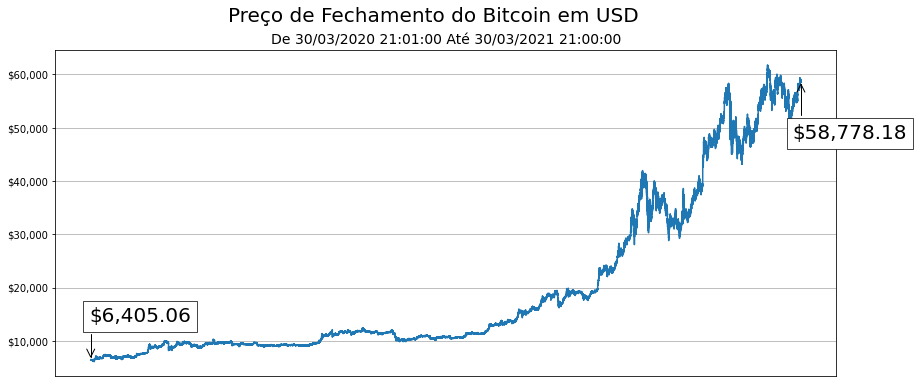

In [4]:
reloadMyModule()

historical_per_day = myFunctions.groupByDay(filtered)
historical_per_hour = myFunctions.groupByHour(filtered)
historical_per_minute = myFunctions.groupByMinute(filtered)

if showGraphs:
    kw = dict(annot_yaxis=10000, annot_xaxis=-1000, annot_xaxis_pos=-6000, annot_yaxis_pos=-
              8000, angle="angle,angleA=0,angleB=90", angle_pos="angle,angleA=0,angleB=-90", showAnnotate=True)
    myFunctions.figureCloses(filtered, 'Close', **kw)


## Gráfico Volatility


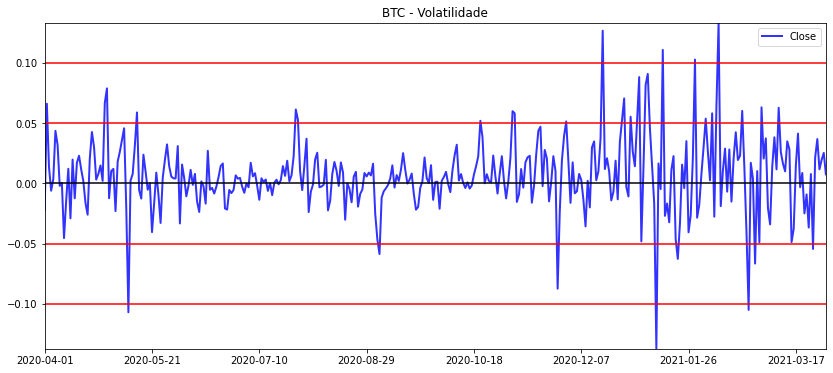

In [5]:
def volatiltyGraph(data):
    returns = data.pct_change().dropna(axis=0)
    plt.figure(figsize=(14, 6))
    plt.title('BTC - Volatilidade')
    plt.grid()
    returns['Close'].plot(label='Close', color='blue',
                          linewidth=2, alpha=0.8, legend=True)
    plt.autoscale(tight=True)
    plt.axhline(y=0, color='black')
    plt.axhline(y=0.05, color='red')
    plt.axhline(y=-0.05, color='red')
    plt.axhline(y=0.1, color='red')
    plt.axhline(y=-0.1, color='red')
    plt.xlabel(None)

    plt.show()


if showGraphs:
    volatiltyGraph(historical_per_day)


## Heatmap


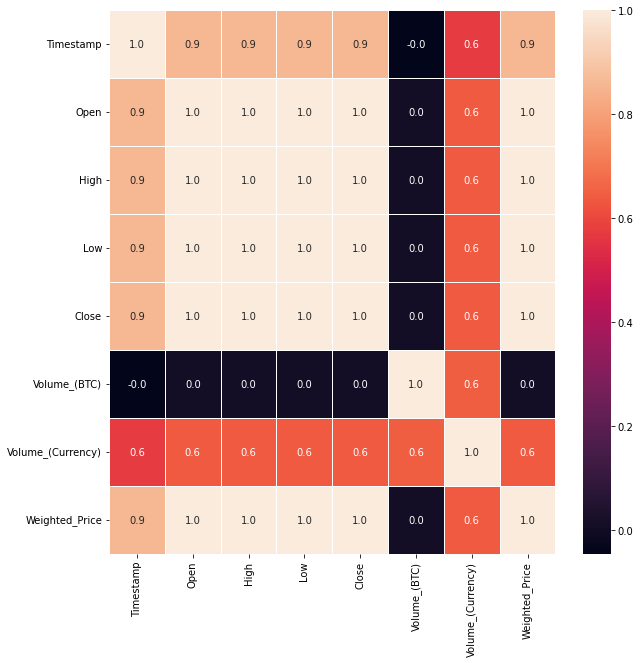

In [6]:
def heatmapGraph(data):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=True,
                linewidths=.9, fmt='.1f', ax=ax)
    plt.show()


if showGraphs:
    heatmapGraph(historical_per_day)


## Dia da semana com valor mais baixo


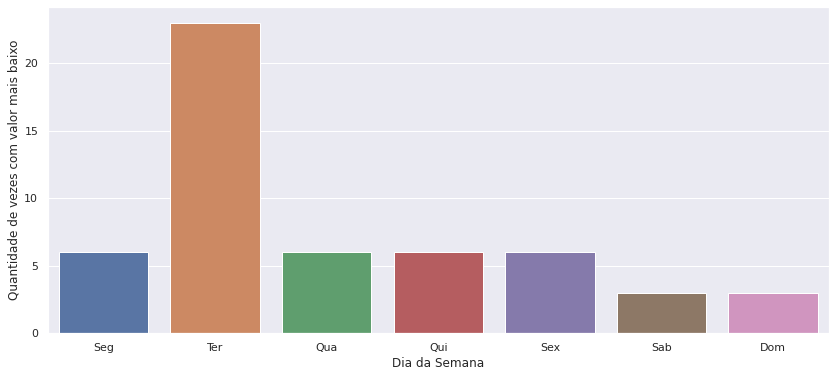

In [7]:
def lowestDuringWeek(data):
    data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    data = data.dropna()

    week = {0: 'Seg', 1: 'Ter', 2: 'Qua',
            3: 'Qui', 4: 'Sex', 5: 'Sab', 6: 'Dom'}
    data['Dia da Semana'] = data['Timestamp'].dt.dayofweek.map(week)

    # count min value for each week day
    idx = data.groupby([pd.Grouper(key='Timestamp', freq='W-MON')]
                       )['Close'].transform(min) == data['Close']

    # data is still in minutes, so I calculate it for days.
    lows_count = data[idx].groupby(
        [pd.Grouper(key='Timestamp', freq='D')]).first().reset_index()
    lows_count = lows_count.dropna()

    sns.set(rc={'figure.figsize': (14, 6)})
    ax = sns.countplot(x='Dia da Semana', data=lows_count, order=[
                       'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])
    ax.set(ylabel='Quantidade de vezes com valor mais baixo')


if showGraphs:
    lowestDuringWeek(historical_per_minute)


# PREPARAÇÃO DOS DADOS PARA OS MODELOS DE APRENDIZADO DE MÁQUINA


In [8]:
reloadMyModule()
# https://www.kaggle.com/code/jeongbinpark/lstm-can-we-predict-the-bitcoin-price


def removeUnusedColumns(df):
    df.drop(['Open', 'Volume_(BTC)', 'Volume_(Currency)',
            'Weighted_Price', 'High', 'Low'], axis=1, inplace=True)
    return df


def groupByTimer(df, interval):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df = df.set_index('Timestamp')
    df = df.resample(interval).mean()
    df = df.dropna()
    return df


def normalize(values):
    scaler = MinMaxScaler()
    return scaler.fit_transform(np.array(values).reshape(-1, 1))


df = removeUnusedColumns(filtered.copy())
df = groupByTimer(df, '1H')
df['Close'] = normalize(df['Close'])
df.describe()
data = df['Close']
# print(df.tail(-5))


In [28]:
def create_dataset(dataset, window=1):
    """
    Estrutura os dados da maneira correta para o treinamento da rede
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - window):
        dataX.append(dataset[i:(i + window)])
        dataY.append(dataset[i + window])
    return np.array(dataX), np.array(dataY)


def separateTrainTest(dataset, projection_Hours):
    """ 
    Separa o dataset em treino e teste.
    Para isso, o dataset é dividido em duas partes:
    1. A primeira parte é usada para treino.
    2. A segunda parte é usada para teste.
    """
    df_train = dataset[:len(dataset)-projection_Hours].values
    df_test = dataset[len(dataset)-projection_Hours:].values
    return df_train, df_test


dias = 15
projection_Hours = 48

df_train, df_test = separateTrainTest(data, dias * 24)
trainX, trainY = create_dataset(df_train, projection_Hours)
testX, testY = create_dataset(df_test, projection_Hours)
# print("Dados de treino_X: {}".format(trainX.shape))
# print("Dados de treino_Y: {}".format(trainY.shape))
# print("Dados de teste_X: {}".format(testX.shape))
# print("Dados de teste_Y: {}".format(testY.shape))

print(len(trainX[0]))
print(round(trainY[0], 8))

# print("-"*100)

# print(trainX[1])
print(round(trainY[1], 8))

# print("-"*100)

print(df_train[0:50])




48
0.00848275
0.00788417
[0.0046422  0.0051826  0.00529038 0.00458293 0.00406601 0.00397181
 0.00422847 0.00457917 0.00508466 0.00507372 0.00420556 0.00353157
 0.00342427 0.00452582 0.00483031 0.004892   0.00467913 0.00445544
 0.00495934 0.00486132 0.00513481 0.00490038 0.00446746 0.00421728
 0.00250215 0.0019073  0.00206947 0.00282989 0.00288006 0.00230333
 0.00198545 0.00230304 0.00205055 0.00184706 0.0019678  0.00170914
 0.00094054 0.0004763  0.00083412 0.00090778 0.00010219 0.00010818
 0.00027701 0.         0.00160343 0.00324979 0.00522352 0.00744509
 0.00848275 0.00788417]


1 - Analisei em utilizar o formato TimeSeriesSplit para separar os dados de treino e teste.

2 - No seguinte exemplo (https://www.kaggle.com/code/someadityamandal/bitcoin-time-series-forecasting) demonstra como obter a precição do próximo valor apenas analisando o atenrior.

3 - Nesse outro exemplo (https://www.kaggle.com/code/someadityamandal/bitcoin-time-series-forecasting) demonstra como obter a precição do próximo valor analisando os 50 valores anteriores.


Escolhi a terceira opção para esse projeto.

In [10]:
regressor = Sequential()
regressor.add(LSTM(units=128, activation='relu', return_sequences=True,
              input_shape=(trainX.shape[1], trainX.shape[2])))
regressor.add(LSTM(units=64, input_shape=(trainX.shape[1], trainX.shape[2])))
regressor.add(Dense(units=1))
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.summary()


2022-06-12 12:13:58.314750: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-06-12 12:13:58.316221: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (darkhold): /proc/driver/nvidia/version does not exist
2022-06-12 12:13:58.323817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


IndexError: tuple index out of range

In [ ]:
# history = regressor.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),verbose=2)
history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 150, verbose=1, shuffle=False, validation_data=(testX, testY))


NameError: name 'regressor' is not defined

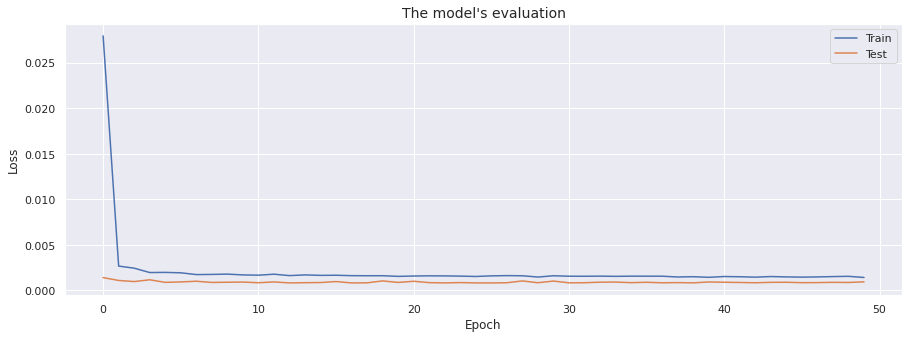

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
x_projection = np.array(df[['Close']])[-projection_Hours:]
print(x_projection)

pr = regressor.predict(x_projection)
pred = []
pred.append(pr[0])


[[0.88743022]
 [0.89089453]
 [0.89223195]
 [0.8896098 ]
 [0.88617244]
 [0.88953406]
 [0.90061424]
 [0.90899136]
 [0.92892925]
 [0.9389826 ]
 [0.93608704]
 [0.94093103]
 [0.9390013 ]
 [0.94034741]
 [0.93458871]
 [0.93151226]
 [0.93772047]
 [0.93497789]
 [0.93332379]
 [0.92844971]
 [0.9279494 ]
 [0.93380014]
 [0.93150326]
 [0.93115164]
 [0.92767961]
 [0.92534191]
 [0.92428352]
 [0.92736707]
 [0.92963479]
 [0.935     ]
 [0.9406798 ]
 [0.93827995]
 [0.94459491]
 [0.95724317]
 [0.9574358 ]
 [0.96035134]
 [0.95749108]
 [0.95407041]
 [0.95217533]
 [0.95104058]
 [0.95328249]
 [0.95614262]
 [0.95504992]
 [0.95121177]
 [0.95176061]
 [0.95319625]
 [0.95102892]
 [0.9530145 ]]
2/2 [==============================] - 2s 4ms/step


# We will predict 300 datas


In [ ]:
# pred = []
# pr = regressor.predict(np.array(df[-50:]))
# pred.append(pr[0])

# for i in range(1,50):
#     arr = np.concatenate((np.array(df[-50+i:]), pred[:]), axis=0)
#     pr = regressor.predict(arr)
#     pred.append(pr[0])

# for i in range(0,250):
#     pr = regressor.predict(np.concatenate(pred[i:],axis=0).reshape(-1,1))
#     pred.append(pr[0])


         Close
0     0.004642
1     0.005183
2     0.005290
3     0.004583
4     0.004066
...        ...
8753  0.951761
8754  0.953196
8755  0.951029
8756  0.953014
8757  0.003143

[8758 rows x 1 columns]


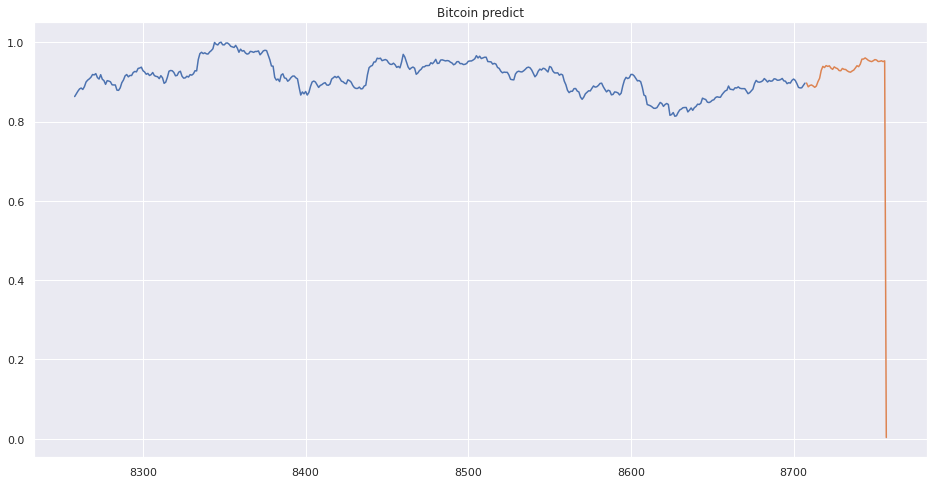

In [ ]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z', 'Close']

pred.drop(['z'], axis=1, inplace=True)

data = pd.concat([df.reset_index().drop(
    'Timestamp', axis=1), pred], ignore_index=True)

print(data)

plt.figure(figsize=(16, 8))
plt.plot(data[-500:-50])
plt.title("Bitcoin predict")
# plt.text(13200,1,"predict data")
# plt.text(13015,1,"- 2020/12/31")
plt.plot(data[-50:])
plt.show()
